<a href="https://colab.research.google.com/github/samarkinav/Two-Sigma-Connect-Rental-Listing-Inquiries/blob/main/multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

import datetime
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

%matplotlib inline

# Чтение данных

In [ ]:
train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')

print('train size:', train_df.shape)
print('test size:', test_df.shape)

train size: (49352, 15)
test size: (74659, 14)


In [ ]:
train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


# Предобработка данных

In [ ]:
train_df.interest_level.value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

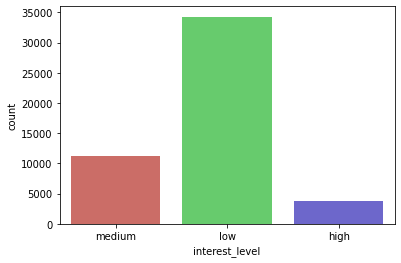

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.countplot(x='interest_level', data=train_df, palette='hls')
plt.show()
plt.savefig('interest_level')

Не будем трогать несбалансированность классов, поскольку для нас важна вероятностная классификация.

In [ ]:
labelencoder = LabelEncoder()
train_df['interest_level'] = labelencoder.fit_transform(train_df['interest_level'])
train_df['interest_level'] = train_df['interest_level'].astype('int')

In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
features_for_model = []

### 1.   bathrooms и bedrooms 



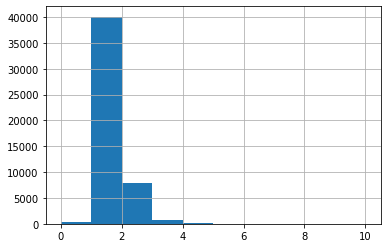

In [ ]:
train_df.bathrooms.hist()

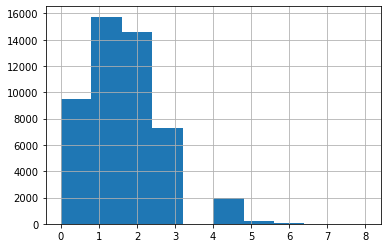

In [ ]:
train_df.bedrooms.hist()

In [ ]:
features_for_model.extend(['bathrooms', 'bedrooms'])

### 3. building_id

In [ ]:
train_df.building_id.value_counts()

0                                   8286
96274288c84ddd7d5c5d8e425ee75027     275
11e1dec9d14b1a9e528386a2504b3afc     215
80a120d6bc3aba97f40fee8c2204524b     213
bb8658a3e432fb62a440615333376345     212
                                    ... 
c6d33d7d6889754340fe231b6bf54ec6       1
8a462db57b6fe7d691fbcd03a24439d1       1
14f63c74768914be6f3707e21ac66a19       1
eafbe31e82540901753bc5b18dd6be6d       1
77000e9b7ef896c9b3d9f8e1c4302621       1
Name: building_id, Length: 7585, dtype: int64

Видим, что во многих объявлениях вообще пропущен этот признак. 

In [ ]:
train_df.building_id.nunique()

7585

Очень много уникальных значений, не будем использовать этот признак в нашей модели.

### 4. created 

In [ ]:
train_df['created'] = pd.to_datetime(train_df['created'])
test_df['created'] = pd.to_datetime(test_df['created'])

На популярность объявления может влиять дата опубликования, конкретнее - может влиять день недели, праздник это или нет. 

In [ ]:
print(min(train_df['created']), max(train_df['created']))

2016-04-01 22:12:41 2016-06-29 21:41:47


Имеем данные за почти 3 месяца. Выделим новые фичи из даты:

In [ ]:
# день недели

train_df['weekday'] = train_df['created'].dt.weekday
test_df['weekday'] = test_df['created'].dt.weekday

In [ ]:
# отдельно выделим выходные + добавим праздники (так как данные всего лишь за 3 месяца, то я вручную нашла, 
# что за этот период был только один государственный праздник - 30 мая)

train_df['day_off'] = np.where(train_df['weekday'] > 4, 1, 0)
test_df['day_off'] = np.where(test_df['weekday'] > 4, 1, 0)
train_df['date'] = train_df['created'].dt.date
test_df['date'] = test_df['created'].dt.date
train_df['day_off'][train_df['date'] == datetime.date(2016, 5, 30)] = 1
test_df['day_off'][test_df['date'] == datetime.date(2016, 5, 30)] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
features_for_model.append('weekday')
features_for_model.append('day_off')

### 5. description

In [ ]:
train_df.description.head(5)

0    Spacious 1 Bedroom 1 Bathroom in Williamsburg!...
1    BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...
2    **FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...
3    A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
4    Over-sized Studio w abundant closets. Availabl...
Name: description, dtype: object

В описании много разнообразной информации. Единственное, что может быть нам интересно - длина описания, потому что чем больше информации предоставил арендодатель - тем больше может быть интерес у клиента.

In [ ]:
def condition(x):
  return '<' not in x and '>' not in x
train_df['description_len'] = train_df.description.apply(lambda x:sum(condition(i) for i in x.split(' ')))
test_df['description_len'] = test_df.description.apply(lambda x:sum(condition(i) for i in x.split(' ')))

In [ ]:
features_for_model.append('description_len')

### 6. display_address и street_address

In [ ]:
train_df[['display_address', 'street_address']].head()

,display_address,street_address
0,145 Borinquen Place,145 Borinquen Place
1,East 44th,230 East 44th
2,East 56th Street,405 East 56th Street
3,Metropolitan Avenue,792 Metropolitan Avenue
4,East 34th Street,340 East 34th Street


Чем отличаются эти два признака? Видимо, во втором к улице добавляется номер дома, хотя в случае с самым первым объявлением - номера дома нет ни в первом столбце, ни во втором. Несут ли эти признаки какую-то информацию? Вряд ли. Не будем использовать их для построения модели.

In [ ]:
train_df.display_address.nunique()

8826

### 7. features

In [ ]:
train_df.features.head(5)

0    [Dining Room, Pre-War, Laundry in Building, Di...
1    [Doorman, Elevator, Laundry in Building, Dishw...
2    [Doorman, Elevator, Laundry in Building, Laund...
3                                                   []
4    [Doorman, Elevator, Fitness Center, Laundry in...
Name: features, dtype: object

Этот признак так же закодируем его длиной.

In [ ]:
train_df['features_len'] = train_df['features'].apply(len)
test_df['features_len'] = test_df['features'].apply(len)

In [ ]:
features_for_model.append('features_len')

### 8. latitude и longitude

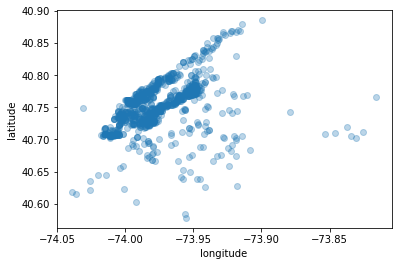

In [ ]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(train_df.shape[0]), size=1000, replace=False)
plt.scatter(train_df.iloc[random_subset]['longitude'], train_df.iloc[random_subset]['latitude'], alpha=0.3)
plt.xlabel('longitude')
plt.ylabel('latitude')
pass

In [ ]:
import math

train_df['x'] = train_df['latitude'].apply(math.cos) * train_df['longitude'].apply(math.cos)
train_df['y'] = train_df['latitude'].apply(math.cos) * train_df['longitude'].apply(math.sin)
train_df['z'] = train_df['latitude'].apply(math.sin) 

test_df['x'] = test_df['latitude'].apply(math.cos) * test_df['longitude'].apply(math.cos)
test_df['y'] = test_df['latitude'].apply(math.cos) * test_df['longitude'].apply(math.sin)
test_df['z'] = test_df['latitude'].apply(math.sin) 

In [ ]:
features_for_model.extend(['x', 'y', 'z'])

### 9. manager_id

In [ ]:
train_df.manager_id.value_counts()

e6472c7237327dd3903b3d6f6a94515a    2533
6e5c10246156ae5bdcd9b487ca99d96a     711
8f5a9c893f6d602f4953fcc0b8e6e9b4     410
62b685cc0d876c3a1a51d63a0d6a8082     402
cb87dadbca78fad02b388dc9e8f25a5b     373
                                    ... 
d9f695c57000c4fdf2250269899ce4a3       1
3260c0c23dc8571dfe655d6a572edebe       1
55dd8427f5672d4f853c23ee843fd5c8       1
df8b1e3a0bc63c1fbe4a2ffc766500e9       1
f388cf2be5cc5a752b19722cf75b5305       1
Name: manager_id, Length: 3481, dtype: int64

Попробуем создать словарь менеджер - сумма очков за интерес к его объявлениям. 

In [ ]:
manager_score = train_df.groupby('manager_id').aggregate({'interest_level':'sum'})\
                                              .rename(columns = {'interest_level':'manager_score'})
manager_score.head()

,manager_score
manager_id,
0000abd7518b94c35a90d64b56fbf3e6,20
001ce808ce1720e24a9510e014c69707,10
003fc4e9a70053082f131b1054966aaf,1
00607a02f6efd9c6c7c588826e471ee9,4
00995ff28d79127ed2dca8320e9e7d09,4


In [ ]:
train_df = train_df.merge(manager_score, how='left', left_on='manager_id', right_on='manager_id')
test_df = test_df.merge(manager_score, how='left', left_on='manager_id', right_on='manager_id')

In [ ]:
test_df.manager_score.isna().sum()

1474

Для каких-то менеджеров в тестовой выборке не нашлось соотвествия из нашего словаря. Заполним для них эти значения медианами.

In [ ]:
test_df.manager_score.fillna(test_df.manager_score.median(axis = 0), axis=0 , inplace=True)

In [ ]:
features_for_model.append('manager_score')

### 10. photos

Вытащим в отдельный признак кол-во фото, прилагаемых к объявлению.

In [ ]:
train_df['photos_count'] = train_df.photos.apply(len)
test_df['photos_count'] = test_df.photos.apply(len)

In [ ]:
features_for_model.append('photos_count')

### 11.price

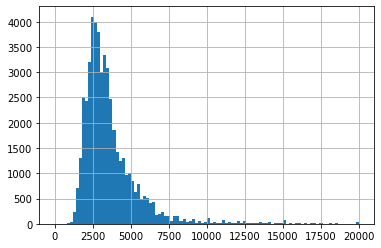

In [ ]:
train_df.price.hist(bins=100, range=(0,20000))

In [ ]:
train_df['price'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     1375.0
0.010     1475.0
0.050     1800.0
0.100     2000.0
0.500     3150.0
0.900     5651.8
0.950     6895.0
0.990    13000.0
0.995    15500.0
Name: price, dtype: float64

In [ ]:
train_df['price_per_room'] = train_df.price / (train_df.bathrooms + train_df.bedrooms)
test_df['price_per_room'] = test_df.price / (test_df.bathrooms + test_df.bedrooms)

In [ ]:
features_for_model.extend(['price', 'price_per_room'])

### 13. listing_id

In [ ]:
train_df = train_df.set_index('listing_id', drop=True)
test_df = test_df.set_index('listing_id', drop=True)

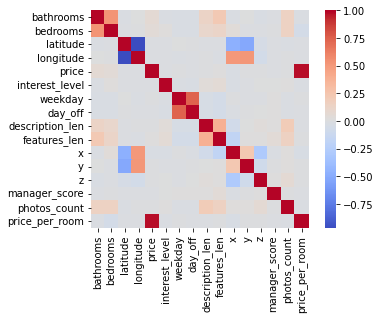

In [ ]:
corr_mat = train_df.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

In [ ]:
corr_mat.where(np.triu(abs(corr_mat) > 0.7, k=1)).stack().sort_values(ascending=False)

price     price_per_room    0.981785
weekday   day_off           0.741510
latitude  longitude        -0.966807
dtype: float64

# Обучение модели

In [ ]:
features_for_model

['bathrooms',
 'bedrooms',
 'weekday',
 'day_off',
 'description_len',
 'features_len',
 'x',
 'y',
 'z',
 'manager_score',
 'photos_count',
 'price',
 'price_per_room']

In [ ]:
X = train_df[features_for_model]
y = train_df['interest_level']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 7170325 to 6901023
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   weekday          49352 non-null  int64  
 3   day_off          49352 non-null  int64  
 4   description_len  49352 non-null  int64  
 5   features_len     49352 non-null  int64  
 6   x                49352 non-null  float64
 7   y                49352 non-null  float64
 8   z                49352 non-null  float64
 9   manager_score    49352 non-null  int64  
 10  photos_count     49352 non-null  int64  
 11  price            49352 non-null  int64  
 12  price_per_room   49352 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 5.3 MB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
lg = lgb.LGBMClassifier(silent=False)
parametrs= {"n_estimators":  range(10,200,5)}
grid_search_cv = GridSearchCV(lg, n_jobs=-1, param_grid=parametrs, cv=5)
grid_search_cv.fit(X_train,y_train)
best_n_estimators = grid_search_cv.best_estimator_.n_estimators
print(best_n_estimators)

170


In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
param = {'objective':'multiclass', 'num_class':3}
num_round = best_n_estimators
bst = lgb.train(param, train_data,num_round, valid_sets=[validation_data])
y_test_predict_proba_lgbm = bst.predict(X_test)

In [ ]:
log_loss(y_test, y_test_predict_proba_lgbm)

0.5901137687186863

Попробуем убрать неинформативные признаки:

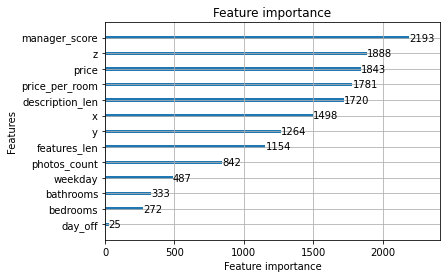

In [ ]:
lgb.plot_importance(bst)

Удалим один из признаков, которые сильно коррелировали между собой (day_off - weekday, price_per_room - price)

In [ ]:
X = X.drop(['day_off', 'price_per_room'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

lg = lgb.LGBMClassifier(silent=False)
parametrs= {"n_estimators":  range(10,200,5)}
grid_search_cv = GridSearchCV(lg, n_jobs=-1, param_grid=parametrs, cv=5)
grid_search_cv.fit(X_train,y_train)
best_n_estimators = grid_search_cv.best_estimator_.n_estimators
print(best_n_estimators)

train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
param = {'objective':'multiclass', 'num_class':3}
num_round = best_n_estimators
bst2 = lgb.train(param, train_data,num_round, valid_sets=[validation_data])
y_test_predict_proba_lgbm = bst2.predict(X_test)

In [ ]:
log_loss(y_test, y_test_predict_proba_lgbm)

0.5904979393355547

# Предсказание на тестовых данных

In [ ]:
predict_proba_lgbm = bst.predict(test_df[features_for_model])

In [ ]:
result = pd.DataFrame(predict_proba_lgbm, columns=['high', 'low', 'medium'], index=test_df.index)
result = result[['high', 'medium', 'low']]

result.head()

,high,medium,low
listing_id,,,
7142618,0.097602,0.406631,0.495767
7210040,0.254445,0.248987,0.496568
7174566,0.019728,0.139932,0.840340
7191391,0.164089,0.528642,0.307269
7171695,0.020667,0.183641,0.795692


In [ ]:
result.to_csv('result.csv')